### Configuration

In [1]:
import os
import ipympl
import numpy as np
import pandas as pd
from scipy import stats

import mne
import yasa
from yasa import sw_detect
from yasa import spindles_detect
from scipy.stats import median_abs_deviation
import plotnine as pn

from utils__helpers_macro import robust_zscore
import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [3]:
fif_path = 'Cache/Subject05/Jul13/S05_Jul13_256hz.fif'
potato_path = 'Cache/Subject05/Jul13/S05_Jul13_potatogram.csv'
dictionary_path = 'Data/Subject05/S05_dictionary.xlsx'
legui_path = 'Cache/Subject05/Jul13/S05_electrodes.csv'
bad_channel_path = 'Cache/Subject05/Jul13/S05_bad_channels.csv'
sw_path = 'Cache/Subject05/Jul13/S05_SW_raw.csv'
kc_path = 'Cache/Subject05/Jul13/S05_KC_raw.csv'
sp_path = 'Cache/Subject05/Jul13/S05_SP_raw.csv'
event_path = 'Cache/Subject05/Jul13/S05_events_summary.csv'

In [4]:
sampling_freq = 256

### Load Data

In [5]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)
print('Original channel count:', len(raw.ch_names))

# Select only macroelectrodes
raw.pick_types(seeg = True, ecog = True)

# Remove rejected channels
bad_channels = pd.read_csv(bad_channel_path)
bad_channels = bad_channels[bad_channels['channel'].isin(raw.ch_names)]
raw.drop_channels(ch_names = bad_channels['channel'].astype('string'))

print('Channel count after Channel Rejection:', len(raw.ch_names))

# Convert V to uV for YASA
data = raw.get_data() * 1e6

# Load hypnogram
hypnogram = np.loadtxt(potato_path, delimiter = ',')

C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\1006497425.py:1: RuntimeWarning: This filename (Cache/Subject05/Jul13/S05_Jul13_256hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Original channel count: 74
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channel count after Channel Rejection: 49


### Normalize with Robust Z-Score

Plot statistics of amplitudes and robust z-scores by channel

In [6]:
pn_data = pd.DataFrame(data.transpose())
pn_data.columns = raw.ch_names
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['index'], var_name = 'channel', value_name = 'amplitude')
pn_data.columns = ['sample', 'channel', 'amplitude']

#pn_data['rzscore'] = pn_data.groupby(['channel'])['amplitude'].transform(robust_zscore)

pn_data = pn_data.groupby(['channel']).agg({'amplitude' : [np.mean,
                                                           np.median,
                                                           lambda x: np.mean(np.abs(x)), 
                                                           lambda x: np.median(np.abs(x)),
                                                           np.std, 
                                                           median_abs_deviation, 
                                                           lambda x: x.quantile(0.10),
                                                           lambda x: x.quantile(0.25),
                                                           lambda x: x.quantile(0.75),
                                                           lambda x: x.quantile(0.90)]})
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['channel'], var_name = ['dummy', 'stat'], value_name = 'value')
pn_data.drop(columns = ['dummy'], inplace = True)
pn_data = pn_data.replace({'stat' : {'<lambda_0>' : 'abs_mean',
                                     '<lambda_1>' : 'abs_median',
                                     'std' : 'sd',
                                     'median_abs_deviation' : 'mad',
                                     '<lambda_2>' : 'q10', 
                                     '<lambda_3>' : 'q25', 
                                     '<lambda_4>' : 'q75', 
                                     '<lambda_5>' : 'q90'}})

amp_data = pn_data.copy(deep = True)
amp_data['stat'] = amp_data['stat'].astype('category')
amp_data['stat'] = amp_data['stat'].cat.reorder_categories(['q90', 'q75', 'q25', 'q10', 'mad', 'abs_median', 'median', 'sd', 'abs_mean', 'mean'])
amp_data.groupby(['stat']).describe().reset_index()

C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\4076147282.py:10: FutureWarning: The provided callable <function mean at 0x000002AF03DB6840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\4076147282.py:10: FutureWarning: The provided callable <function median at 0x000002AF03EF7880> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\4076147282.py:10: FutureWarning: The provided callable <function std at 0x000002AF03DB6A20> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\4076147282.py:36: FutureWar

stat value                                                         \
              count       mean        std        min        25%        50%   
0         q90  49.0  51.933681  18.288142  22.662119  38.237068  50.960815   
1         q75  49.0  24.554529   8.078083  11.157910  18.528026  24.422935   
2         q25  49.0 -24.928532   8.487680 -43.148484 -29.673053 -24.462806   
3         q10  49.0 -52.037292  18.333779 -91.659999 -60.985191 -50.555218   
4         mad  49.0  24.738686   8.258806  10.814748  18.336681  24.527700   
5  abs_median  49.0  24.752422   8.268387  10.820352  18.346278  24.527940   
6      median  49.0  -0.219518   0.775301  -2.594196  -0.572420  -0.109113   
7          sd  49.0  50.140293  16.679788  26.654639  38.273729  47.424514   
8    abs_mean  49.0  34.361367  11.856229  17.345447  25.474061  33.736873   
9        mean  49.0   0.001972   0.309052  -0.707973  -0.178983  -0.007728   

                         
         75%        max  
0  60.509856  94.423653  
1  29.012869  44.854826  
2 -18.155238 -10.471816  
3 -38.896099 -22.037309  
4  29.326416  44.002777  
5  29.331003  44.004892  
6   0.297457   1.522202  
7  61.060518  86.576695  
8  40.756263  59.784958  
9   0.170205   0.735274

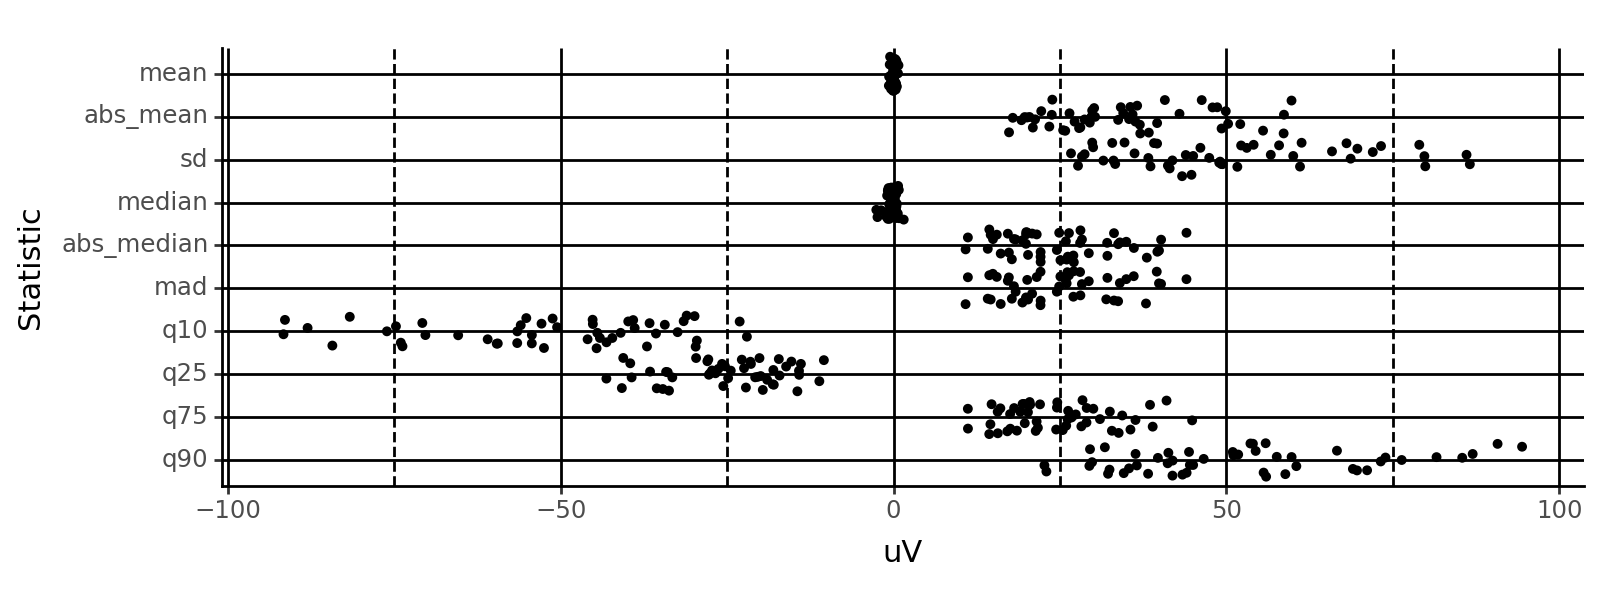

<Figure Size: (800 x 300)>

In [7]:
(pn.ggplot(amp_data)
 + pn.aes(x = 'stat', y = 'value')
 + pn.geom_jitter(size = 1)
 + pn.labs(x = 'Statistic', y = 'uV')
 + pn.theme_classic()
 + pn.theme(figure_size = (8, 3),
            panel_grid_major = pn.element_line(linetype = 'solid'),
            panel_grid_minor = pn.element_line(linetype = 'dashed'))
 + pn.coord_flip()
)

In [8]:
ex_uV = 100

ex_data = amp_data.groupby(['stat']).describe().reset_index()
ex_median = ex_data[ex_data.stat == 'median']['value']['mean'].item()
ex_mad = ex_data[ex_data.stat == 'mad']['value']['mean'].item()
ex_mean = ex_data[ex_data.stat == 'mean']['value']['mean'].item()
ex_sd = ex_data[ex_data.stat == 'sd']['value']['mean'].item()

ex_rzs = np.round(( 0.6745 * (ex_uV - ex_median) ) / ex_mad, decimals = 2)
ex_zs = np.round((ex_uV - ex_mean) / ex_sd, decimals = 2)

print(ex_uV, 'uV equals', ex_rzs, 'robust z-scores and', ex_zs, 'z-scores (for the average channel in this subject).')

100 uV equals 2.73 robust z-scores and 1.99 z-scores (for the average channel in this subject).


C:\Users\lal85\AppData\Local\Temp\2\ipykernel_26832\3855422016.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Convert uV to channel-wise robust z-score

In [9]:
# rz_data = stats.zscore(data, axis = 0)
rz_data = np.apply_along_axis(func1d = robust_zscore, axis = 0, arr = data)

### Slow Wave Detection

In [10]:
# SleepTrip equivalent parameters (for comparison): 
# Bandpass:                         0.2 - 4 Hz (Subject01), 0.5 - 4 Hz (Subject02)
# Duration of entire SW:            0.5 - 3.3 seconds
# Minimum of positive peak:         25 uV
# Maximum of negative peak:         -50 uV (Subject01), -100 uV (Subject02)
# Peak-to-trough amplitude:         200 - 5000 uV
# Outlier removal:                  100 standard deviations

# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
sw = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include SW's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 1.5), # bandpass to look at SW's (Hz); default (0.3, 1.5)
               dur_neg = (0.3, 1.5), # min/max duration of negative deflection (seconds); default (0.3, 1.5)
               dur_pos = (0.1, 1.5), # min/max duration of positive reflection (seconds); default (0.1, 1.0)
               amp_neg = (1.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None); default (40, 200)
               amp_pos = (1.0, None), # min/max peak amplitude of positive reflection (uV); can be (None, None); default (10, 150)
               amp_ptp = (4.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf; default (75, 350)
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

slow_waves = sw.summary()
slow_waves['ID'] = slow_waves.index + 1

# Save to CSV and print summary/plot
sw.summary(grp_stage = True)
#sw.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
10-Sep-23 11:15:00 | WARNING | No SW were found in channel LOF10.
10-Sep-23 11:15:01 | WARNING | No SW were found in channel LOF11.
10-Sep-23 11:15:03 | WARNING | No SW were found in channel RSMA7.


,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,58139,192.407060,1.142911,-2.761068,2.562181,5.323249,21.696263,0.929679
3,5401,339.329843,1.232730,-2.796954,2.615085,5.412039,20.113021,0.854533


In [11]:
sw.compare_channels()

Channel,LOF1,RPHC8,RPHC9,RPC1,RPC3,RPC6,RPC8,RPC9,RPC10,RSMA4,...,RAM2,RAM5,RAM6,RAM7,RAM8,LOF9,RHC5,RHC6,RHC7,RHC8
Channel,,,,,,,,,,,,,,,,,,,,,
LOF1,1.000000,0.007047,0.000000,0.0,0.000785,0.005828,0.004552,0.000000,0.000793,0.006279,...,0.010962,0.009771,0.017466,0.003704,0.003060,0.011565,0.014116,0.017678,0.007338,0.017022
RPHC8,0.007047,1.000000,0.000000,0.0,0.013270,0.011012,0.006483,0.000000,0.001992,0.003540,...,0.013241,0.004777,0.003149,0.004405,0.001681,0.004011,0.027577,0.019382,0.008172,0.010473
RPHC9,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPC1,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPC3,0.000785,0.013270,0.000000,0.0,1.000000,0.030717,0.010899,0.000000,0.000000,0.002415,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003180,0.002754,0.001731,0.000000,0.002048
RPC6,0.005828,0.011012,0.000000,0.0,0.030717,1.000000,0.054902,0.003906,0.000000,0.003263,...,0.001901,0.000979,0.004433,0.004479,0.000000,0.009737,0.005433,0.005692,0.002686,0.007898
RPC8,0.004552,0.006483,0.000000,0.0,0.010899,0.054902,1.000000,0.047782,0.012658,0.000000,...,0.000000,0.001096,0.000804,0.005935,0.000000,0.000000,0.005089,0.005485,0.001575,0.001958
RPC9,0.000000,0.000000,0.000000,0.0,0.000000,0.003906,0.047782,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000522
RPC10,0.000793,0.001992,0.000000,0.0,0.000000,0.000000,0.012658,0.000000,1.000000,0.002574,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001171,0.000000,0.000519


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

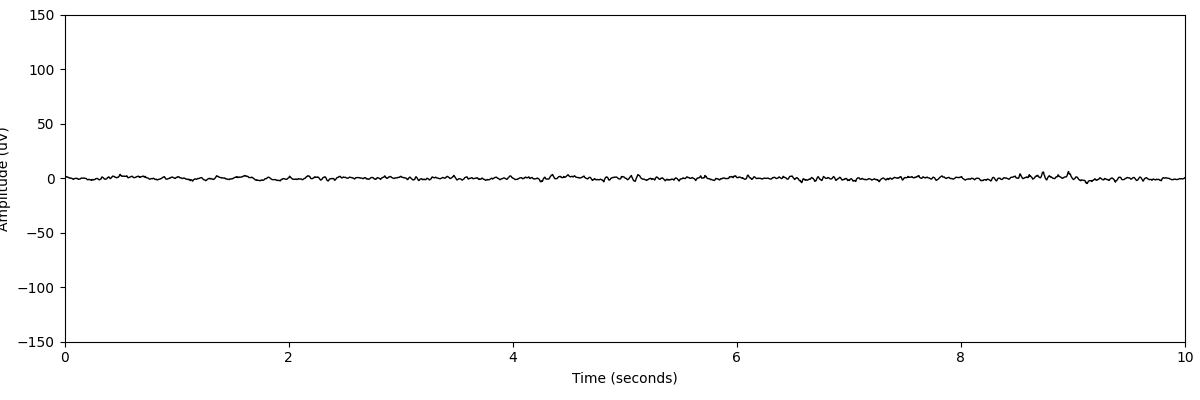

In [12]:
%matplotlib widget
sw.plot_detection()

### K-Complex Detection

In [13]:
# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
kc = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include KC's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 4.0), # bandpass to look at events (Hz) 
               dur_neg = (0.3, 1), # min/max duration of negative deflection (seconds)
               dur_pos = (0.1, 0.5), # min/max duration of positive reflection (seconds)
               amp_neg = (5.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None)
               amp_pos = (None, None), # min/max peak amplitude of positive reflection (uV); can be (None, None)
               amp_ptp = (5.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

k_complexes = kc.summary()
k_complexes['ID'] = k_complexes.index + 1

# Print summary/plot
kc.summary(grp_stage = True)
#kc.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
10-Sep-23 11:16:18 | WARNING | No SW were found in channel LOF10.
10-Sep-23 11:16:18 | WARNING | No SW were found in channel RPHC9.
10-Sep-23 11:16:18 | WARNING | No SW were found in channel RPC1.
10-Sep-23 11:16:18 | WARNING | No SW were found in channel LOF11.
10-Sep-23 11:16:19 | WARNING | No SW were found in channel RPC3.
10-Sep-23 11:16:19 | WARNING | No SW were found in channel RPC8.
10-Sep-23 11:16:19 | WARNING | No SW were found in channel RPC9.
10-Sep-23 11:16:19 | WARNING | No SW were found in channel RPC10.
10-Sep-23 11:16:20 | WARNING | No SW were found in channel RSMA7.
10-Sep-23 11:16:20 | WARNING | No SW were found in channel LAC8.
10-Sep-23 11:16:21 | WARNING | No SW were found in channel LAM4.
10-Sep-23 11:16:22 | WARNING | No SW were found in channel LHC5.
10-Sep-23 11:16:23 | WARNING | No SW were found in channel ROF5.
10-Sep-23 11:16:24 | WARNING | No SW were found in channel ROF8.
10-Sep-23 11:16:24 | WAR

,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,4309,14.260342,0.765175,-6.074443,2.938857,9.013299,52.532094,1.358798
3,182,11.434555,0.840831,-5.899522,2.636960,8.536482,41.707906,1.240390


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

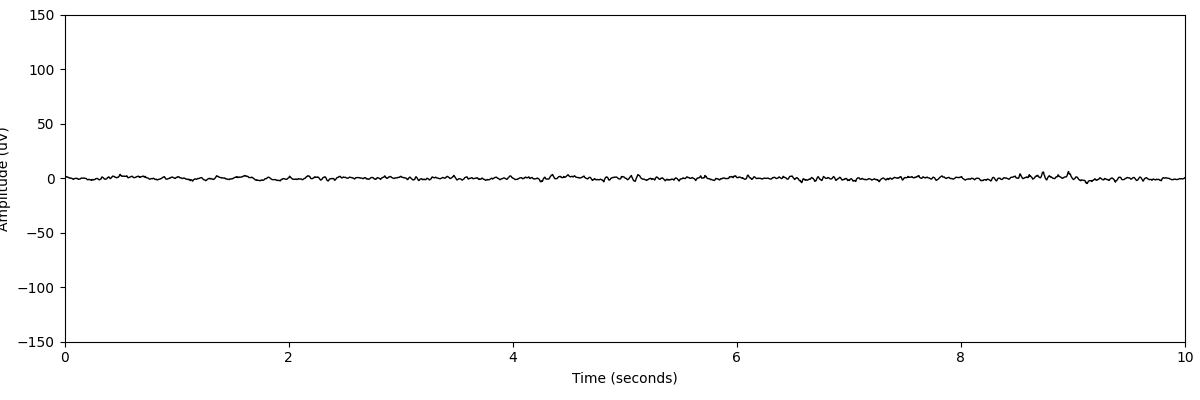

In [14]:
%matplotlib widget
kc.plot_detection()

### Spindle Detection

In [15]:
sp = spindles_detect(data,
                     sf = sampling_freq,
                     ch_names = raw.ch_names,
                     hypno = hypnogram, # optionally load a hypnogram file
                     include = (2, 3), # only include spindles detected in N2 and N3 sleep (if hyponogram is specified)
                     freq_sp = (12, 15), # bandpass to look at spindles (Hz)
                     freq_broad = (1, 30), # broadband frequency range (Hz)
                     duration = (0.5, 2), # min/max duration of spindles (seconds)
                     min_distance = 500, # merge threshold of adjacent spindles (milliseconds)
                     #thresh = {'rel_pow': ?it's a ratio?, # relative power (freq_sp / freq_broad)
                     #          'corr': ?, # moving correlation between original and sigma-filtered signals
                     #          'rms': ?}, # standard deviations above mean of moving RMS of sigma-filtered signal
                     multi_only = False, # if True, only keeps spindles present in at least two channels
                     remove_outliers = True, # detect and remove outliers using sklearn's Isolation Forest
                     )

spindles = sp.summary()
spindles['ID'] = spindles.index + 1

# Print summary/plot
sp.summary(grp_stage = True)
#sp.plot_average(center = 'Peak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
10-Sep-23 11:18:42 | WARNING | No spindle were found in channel LAM1.
10-Sep-23 11:19:55 | WARNING | No spindle were found in channel RAM1.


,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,41880,138.599007,1.068545,156.567857,32.575078,2.920557,0.414073,13.313848,13.205301,0.520789
3,821,51.581152,0.910408,173.420083,38.153313,3.086208,0.352520,13.169240,11.582217,0.530100


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

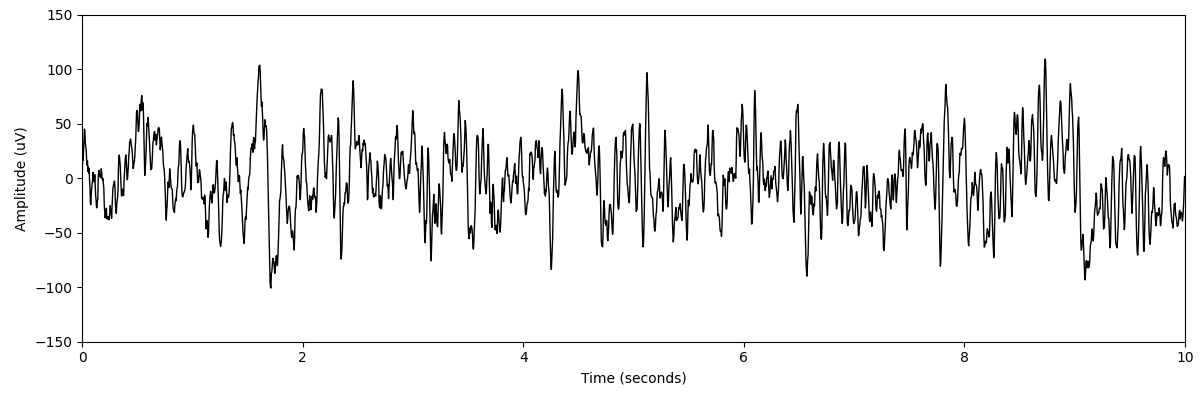

In [16]:
%matplotlib widget
sp.plot_detection()

### Summarize Events & Export

Remove channel events if the channel detected less than the event threshold.

In [17]:
# Extract event counts by channel
sw_sum = sw.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sw_sum = sw_sum[['Channel', 'Count']]
sw_sum.columns = ['channel', 'sw']

kc_sum = kc.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
kc_sum = kc_sum[['Channel', 'Count']]
kc_sum.columns = ['channel', 'kc']

sp_sum = sp.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sp_sum = sp_sum[['Channel', 'Count']]
sp_sum.columns = ['channel', 'sp']

# Merge event counts and export to CSV
event_sum = pd.merge(sw_sum, kc_sum, on = ['channel'])
event_sum = pd.merge(event_sum, sp_sum, on = ['channel'])
event_sum.to_csv(event_path, index = False)

# Save sleep events to CSV
slow_waves.to_csv(sw_path, index = False)
k_complexes.to_csv(kc_path, index = False)
spindles.to_csv(sp_path, index = False)